# Interactive DICOM Tutorial

This tutorial guides you through working with RT DICOM files in Python.

## Setup

In [1]:
# Install required libraries
!pip install pydicom matplotlib numpy pandas scikit-image

# Import libraries
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from pydicom.dataset import Dataset, FileDataset
from pydicom.sequence import Sequence
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

## 1. Loading DICOM Images

In [2]:
# Define path to the CT dataset
patient_id = "01149188"  # Change this to the patient you want to analyze
path = f"data/test-cases/{patient_id}/"

# Find all CT slices
ct_files = [f for f in os.listdir(path) if f.startswith("CT")]
ct_files.sort()  # Sort to get them in order

# Load the middle slice for demonstration
middle_index = len(ct_files) // 2
middle_slice_path = os.path.join(path, ct_files[middle_index])
ct_slice = pydicom.dcmread(middle_slice_path)

# Display basic info
print(f"Patient ID: {ct_slice.PatientID}")
print(f"Modality: {ct_slice.Modality}")
print(f"Slice Location: {ct_slice.SliceLocation}")
print(f"Pixel Spacing: {ct_slice.PixelSpacing}")
print(f"Total slices: {len(ct_files)}")

Patient ID: 01149188
Modality: CT
Slice Location: -280.000
Pixel Spacing: [1.269531, 1.269531]
Total slices: 188


## 2. Visualizing a CT Slice

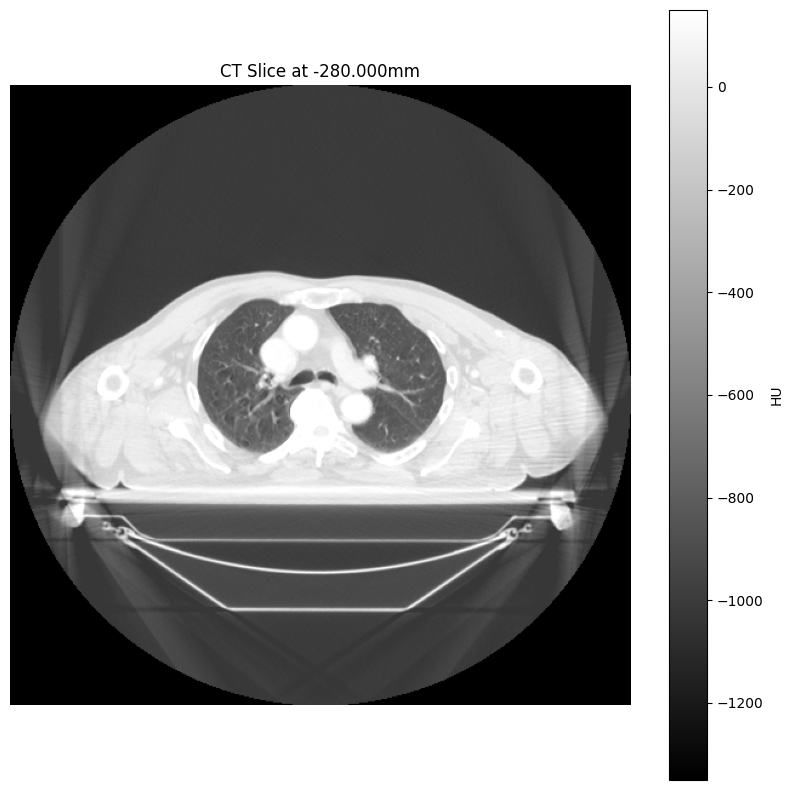

In [3]:
# Function to convert pixel data to Hounsfield Units (HU)
def get_hu_values(ct_slice):
    """
    Convert CT pixel data to Hounsfield Units using the rescale slope and intercept
    
    Hounsfield Units (HU) are a standardized scale for reporting CT numbers:
    - Air: approximately -1000 HU
    - Water: 0 HU
    - Soft tissue: 20-100 HU
    - Bone: 300-1900 HU
    """
    # Get pixel values
    pixel_array = ct_slice.pixel_array
    
    # Convert to HU using slope and intercept
    intercept = ct_slice.RescaleIntercept
    slope = ct_slice.RescaleSlope
    
    hu_values = pixel_array * slope + intercept
    return hu_values

# Get HU values and display the image
hu_image = get_hu_values(ct_slice)

# Set window/level for better visualization (lung window)
window_center = -600  # Center of the window in HU
window_width = 1500   # Width of the window in HU

# Apply window/level
# This controls the brightness/contrast by limiting displayed HU range:
# - Values below (window_center - window_width/2) appear black
# - Values above (window_center + window_width/2) appear white
# - Values in between are mapped to grayscale
min_value = window_center - window_width/2
max_value = window_center + window_width/2
hu_image_windowed = np.clip(hu_image, min_value, max_value)

# Common window/level presets:
# - Lung: -600/1500 (shows air-filled structures)
# - Soft tissue: 40/400 (optimal for organs)
# - Bone: 500/2000 (best for visualizing bones)
# - Brain: 40/80 (for brain tissue contrast)

# Display image
plt.figure(figsize=(10, 10))
plt.imshow(hu_image_windowed, cmap='gray')
plt.title(f"CT Slice at {ct_slice.SliceLocation}mm")
plt.axis('off')
plt.colorbar(label='HU')
plt.show()

## 3. Exploring DICOM Metadata

In [ ]:
# Function to display DICOM tags in a user-friendly way
def explore_dicom_tags(ds, max_depth=2, current_depth=0, prefix=''):
    """
    Recursively explore DICOM tags with controlled depth
    
    Parameters:
        ds: The DICOM dataset to explore
        max_depth: Maximum recursion depth for nested sequences (default=2)
                   Controls how deep to go into nested DICOM sequences:
                   - 0: Only show top-level tags
                   - 1: Show one level of sequence items
                   - 2+: Show deeper nested sequences
        current_depth: Current recursion depth (used internally)
        prefix: String prefix for indentation (used internally)
    
    Returns:
        List of formatted tag descriptions
    """
    tags_info = []
    
    # Skip Pixel Data because it's too large
    skip_tags = [(0x7FE0, 0x0010)]  # Pixel Data (the information required to rebuild/show the image)
    
    for elem in ds:
        if elem.tag in skip_tags:
            tags_info.append(f"{prefix}{elem.tag}: [Pixel Data]")
            continue
            
        # Format the element
        if elem.VR == "SQ":  # Sequence
            tags_info.append(f"{prefix}{elem.tag} {elem.name}: Sequence with {len(elem.value)} item(s)")
            if current_depth < max_depth:
                for i, item in enumerate(elem.value):
                    tags_info.append(f"{prefix}  Item {i}:")
                    tags_info.extend(explore_dicom_tags(item, max_depth, current_depth + 1, prefix + '    '))
        else:
            if elem.VM > 1:  # Multiple values
                tags_info.append(f"{prefix}{elem.tag} {elem.name}: {elem.repval}")
            else:
                tags_info.append(f"{prefix}{elem.tag} {elem.name}: {elem.repval}")
    
    return tags_info

# Display the first 20 tags
tags = explore_dicom_tags(ct_slice, max_depth=1)
for tag in tags[:20]:
    print(tag)

print("...")
print(f"Total tags: {len(tags)}")

(0008,0000) Group Length: 592
(0008,0005) Specific Character Set: 'ISO_IR 100'
(0008,0008) Image Type: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0012) Instance Creation Date: '20181017'
(0008,0013) Instance Creation Time: '160716'
(0008,0016) SOP Class UID: CT Image Storage
(0008,0018) SOP Instance UID: 1.2.840.113619.2.55.3.2831218210.826.1539778042.155.184
(0008,0020) Study Date: '20181017'
(0008,0021) Series Date: '20181017'
(0008,0022) Acquisition Date: '20181017'
(0008,0023) Content Date: '20181017'
(0008,0030) Study Time: '160240'
(0008,0031) Series Time: '160450'
(0008,0032) Acquisition Time: '160605'
(0008,0033) Content Time: '160716'
(0008,0050) Accession Number: ''
(0008,0060) Modality: 'CT'
(0008,0070) Manufacturer: 'GE MEDICAL SYSTEMS'
(0008,0080) Institution Name: ''
(0008,0090) Referring Physician's Name: ''
...
Total tags: 209


## 4. Searching for Specific DICOM Tags

In [5]:
# Function to search for tags by keyword
def search_dicom_tags(ds, keyword, case_sensitive=False):
    """Search for DICOM tags containing a keyword"""
    results = []
    
    if not case_sensitive:
        keyword = keyword.lower()
    
    for elem in ds:
        # Skip pixel data
        if elem.tag == (0x7FE0, 0x0010):
            continue
            
        # Check if keyword is in the tag name
        elem_name = elem.name if case_sensitive else elem.name.lower()
        if keyword in elem_name:
            results.append((elem.tag, elem.name, elem.repval))
    
    return results

# Search for tags containing "patient"
patient_tags = search_dicom_tags(ct_slice, "patient")
print("Tags related to patient:")
for tag, name, value in patient_tags:
    print(f"{tag} {name}: {value}")

# Search for tags containing "study"
study_tags = search_dicom_tags(ct_slice, "study")
print("\nTags related to study:")
for tag, name, value in study_tags:
    print(f"{tag} {name}: {value}")

Tags related to patient:
(0010,0010) Patient's Name: '01149188'
(0010,0020) Patient ID: '01149188'
(0010,0030) Patient's Birth Date: '19460411'
(0010,0040) Patient's Sex: 'M'
(0010,1010) Patient's Age: '072Y'
(0010,21B0) Additional Patient History: ''
(0018,1111) Distance Source to Patient: '605.945007'
(0018,5100) Patient Position: 'HFS'
(0020,0032) Image Position (Patient): [-325.000, -325.000, -280.000]
(0020,0037) Image Orientation (Patient): [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]

Tags related to study:
(0008,0020) Study Date: '20181017'
(0008,0030) Study Time: '160240'
(0008,1030) Study Description: 'IMRT H&N'
(0008,1060) Name of Physician(s) Reading Study: ''
(0020,000D) Study Instance UID: 1.2.840.113619.2.55.3.2831218210.826.1539778041.958
(0020,0010) Study ID: '22043'


## 5. Loading RT Structure Set

In [13]:
# Find and load the RT Structure Set file
rs_files = [f for f in os.listdir(path) if f.startswith("RS")]
if rs_files:
    rs_path = os.path.join(path, rs_files[0])
    rs = pydicom.dcmread(rs_path)
    print(f"Loaded RT Structure Set: {rs_path}")
    print(f"Structure Set Label: {rs.StructureSetLabel}")
    print(f"Structure Set Date: {rs.StructureSetDate}")
    
    # List all structures
    roi_sequence = rs.StructureSetROISequence
    print(f"\nTotal structures: {len(roi_sequence)}")
    
    structures = []
    for i, roi in enumerate(roi_sequence):
        structures.append({
            'Number': roi.ROINumber,
            'Name': roi.ROIName,
        })
    
    # Display as a table
    df = pd.DataFrame(structures)
    print(df)
else:
    print("No RT Structure Set found")

Loaded RT Structure Set: data/test-cases/01149188/RS.1.3.46.670589.13.401416.20210323111416.655680
Structure Set Label: TONSIL_LNs
Structure Set Date: 20210323

Total structures: 28
    Number              Name
0        1            MARKED
1        2         FINAL ISO
2        3           PTV6996
3        4    PTV 5700 FINAL
4        5     couch removal
5        6      elekta couch
6        7            Larynx
7        8              BP_R
8        9              BP_L
9       10              SKIN
10      11          SKIN-3MM
11      12      GTV R Tonsil
12      13           GTV LNs
13      14    CTV Right Neck
14      15     CTV Left Neck
15      16              Cord
16      17                NT
17      18          Mandible
18      19         BrainStem
19      20         R Cochlea
20      21         L Cochlea
21      22         R Parotid
22      23         L Parotid
23      24          Override
24      25          Contrast
25      26      CTV R Tonsil
26      27    Esophagus PART
27    

## 6. Visualizing RT Structures on CT *(currently buggy)*

Current slice position: Z=-280.000mm (index 4 of 188)


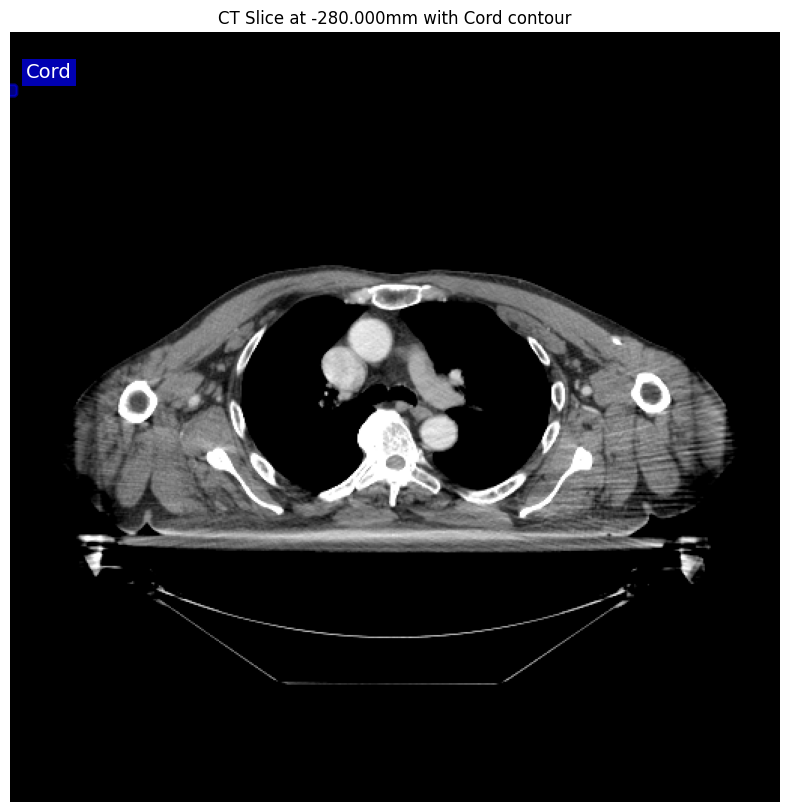

Displaying 1 contours for Cord
Cord exists on 106 slices, from -285.0mm to -22.5mm


In [16]:
# Function to get contour data for a specific structure
def get_contour_data(rs, structure_name):
    """
    Extract contour data for a specific structure name from an RT Structure Set
    
    In DICOM RT:
    - Each structure (ROI) has a unique ROI Number
    - Structure contours are stored as 3D coordinates in patient space (mm)
    - Each contour is typically a closed polygon on a specific slice
    - Multiple contours may exist for the same structure across different slices
    """
    # First, find the ROI number for the structure name
    roi_number = None
    for roi in rs.StructureSetROISequence:
        if roi.ROIName == structure_name:
            roi_number = roi.ROINumber
            break
    
    if roi_number is None:
        print(f"Structure {structure_name} not found")
        return None
    
    # Next, find the contour data for this ROI number
    contour_data = []
    for roi_contour in rs.ROIContourSequence:
        if roi_contour.ReferencedROINumber == roi_number:
            # Get the color
            color = [c/255 for c in roi_contour.ROIDisplayColor]
            
            # Get the contour sequence
            if hasattr(roi_contour, 'ContourSequence'):
                for contour in roi_contour.ContourSequence:
                    contour_coords = contour.ContourData
                    # Reshape into x,y,z triplets
                    triplets = np.array(contour_coords).reshape((-1, 3))
                    contour_data.append({
                        'triplets': triplets,
                        'z': triplets[0, 2],  # Z coordinate (slice location)
                        'color': color
                    })
    
    return contour_data

# Get all CT slice locations for reference
def get_all_slice_locations():
    """Get a sorted list of all CT slice locations with their filenames"""
    slice_positions = []
    for f in ct_files:
        try:
            ds = pydicom.dcmread(os.path.join(path, f))
            slice_positions.append((f, ds.SliceLocation))
        except:
            continue
    slice_positions.sort(key=lambda x: x[1])
    return slice_positions

# Function to visualize a structure on a CT slice
def visualize_structure(structure_name, slice_z=None):
    """
    Visualize a structure on a CT slice
    
    Parameters:
        structure_name: Name of the structure to visualize
        slice_z: Z position of the slice to display (if None, use current_slice)
                 Z positions in DICOM are in millimeters in the patient coordinate system
                 - Larger Z values indicate superior direction (head)
                 - Smaller Z values indicate inferior direction (feet)
    
    The visualization process:
    1. Find the CT slice closest to the requested Z position
    2. Apply appropriate windowing for the anatomical region
    3. Find structure contours at this Z position (with tolerance)
    4. Transform contour points from patient to pixel coordinates
    5. Display the CT slice with structure contours overlaid
    """
    # Get all slice locations
    slice_positions = get_all_slice_locations()
    
    # If no specific slice is provided, use the current one
    if slice_z is None:
        target_slice = ct_slice
        target_z = current_z
    else:
        # Find the closest CT slice to the requested Z position
        closest_file = min(slice_positions, key=lambda x: abs(x[1] - slice_z))[0]
        target_slice = pydicom.dcmread(os.path.join(path, closest_file))
        target_z = target_slice.SliceLocation
        print(f"Requested Z={slice_z}mm, using closest slice at Z={target_z}mm")
    
    # Get HU values for this slice
    hu_image = get_hu_values(target_slice)
    
    # Set appropriate window/level based on anatomy
    if structure_name in ["Cord", "BrainStem"]:
        window_center = 40
        window_width = 400
    elif structure_name in ["Mandible"]:
        window_center = 500
        window_width = 2000
    else:
        window_center = -600
        window_width = 1500
    
    min_value = window_center - window_width/2
    max_value = window_center + window_width/2
    hu_image_windowed = np.clip(hu_image, min_value, max_value)
    
    # Get contour data
    contour_data = get_contour_data(rs, structure_name)
    
    if contour_data:
        # Display the CT slice with structure overlay
        plt.figure(figsize=(10, 10))
        plt.imshow(hu_image_windowed, cmap='gray')
        
        # Find contours on this slice with increased tolerance
        # The atol parameter controls how far (in mm) from the exact slice
        # position to look for contours - increase for thicker slices
        contours_on_slice = [c for c in contour_data if np.isclose(c['z'], target_z, atol=1.0)]
        
        # If no contours are found with the default tolerance, try a larger one
        if not contours_on_slice:
            contours_on_slice = [c for c in contour_data if np.isclose(c['z'], target_z, atol=2.0)]
            if contours_on_slice:
                print(f"Using increased tolerance (2.0mm) to find contours")
        
        # Add contours to the plot
        patches = []
        for contour in contours_on_slice:
            # Extract x,y coordinates
            points = contour['triplets'][:, :2]
            polygon = Polygon(points, closed=True)
            patches.append(polygon)
        
        # Create a collection and add it to the plot
        if patches:
            color = contour_data[0]['color']
            collection = PatchCollection(patches, alpha=0.5, color=color, linewidths=2, edgecolor=color)
            plt.gca().add_collection(collection)
            
            # Add structure label to plot
            plt.text(10, 30, structure_name, 
                     color='white', fontsize=14, 
                     bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=3))
        
        plt.title(f"CT Slice at {target_z}mm with {structure_name} contour")
        plt.axis('off')
        plt.show()
        
        if contours_on_slice:
            print(f"Displaying {len(contours_on_slice)} contours for {structure_name}")
            
            # Show a sample of Z positions where this structure exists
            z_positions = sorted([c['z'] for c in contour_data])
            print(f"{structure_name} exists on {len(set(z_positions))} slices, from {min(z_positions):.1f}mm to {max(z_positions):.1f}mm")
        else:
            print(f"No contours found for {structure_name} at slice Z={target_z}mm")
            # Suggest a slice where this structure exists
            if contour_data:
                contour_z_positions = [c['z'] for c in contour_data]
                closest_z = min(contour_z_positions, key=lambda z: abs(z - target_z))
                print(f"Hint: This structure has a contour at Z={closest_z}mm")
                
                # Suggest slice index to load
                closest_file_idx = next((i for i, pos in enumerate(slice_positions) if np.isclose(pos[1], closest_z, atol=0.5)), None)
                if closest_file_idx is not None:
                    print(f"Try loading CT slice at index {closest_file_idx} to see this structure")
    else:
        print(f"No contour data found for {structure_name}")

# Get the Z coordinate of our current slice
current_z = ct_slice.SliceLocation
slice_idx = next((i for i, pos in enumerate(get_all_slice_locations()) if pos[1] == current_z), None)
print(f"Current slice position: Z={current_z}mm (index {slice_idx} of {len(ct_files)})")

# Predefined slice/structure combinations
# Uncomment ONE of these blocks to demonstrate different structures

# ===== EXAMPLE 1: Spinal Cord at current slice (thoracic level) =====
visualize_structure("Cord")  # at current slice location (-280mm)

# ===== EXAMPLE 2: Mandible in head region =====
# visualize_structure("Mandible", slice_z=-180)  # higher in head

# ===== EXAMPLE 3: Left Parotid gland =====
# visualize_structure("L Parotid", slice_z=-220)

# ===== EXAMPLE 4: GTV (Gross Tumor Volume) in tonsil region =====
# visualize_structure("GTV R Tonsil", slice_z=-230)

# ===== EXAMPLE 5: PTV (Planning Target Volume) =====
# visualize_structure("PTV6996", slice_z=-230)

# ===== EXAMPLE 6: Brain Stem =====
# visualize_structure("BrainStem", slice_z=-160)

## 7. Loading RT Plan

In [8]:
# Find and load the RT Plan file
rp_files = [f for f in os.listdir(path) if f.startswith("RP")]
if rp_files:
    rp_path = os.path.join(path, rp_files[0])
    rp = pydicom.dcmread(rp_path)
    print(f"Loaded RT Plan: {rp_path}")
    print(f"Plan Label: {rp.RTPlanLabel}")
    print(f"Plan Date: {rp.RTPlanDate}")
    
    # Display prescription information
    if hasattr(rp, 'DoseReferenceSequence'):
        print("\nPrescription Information:")
        for dose_ref in rp.DoseReferenceSequence:
            if hasattr(dose_ref, 'TargetPrescriptionDose'):
                print(f"Target Prescription Dose: {dose_ref.TargetPrescriptionDose} Gy")
    
    # Display beam information
    if hasattr(rp, 'BeamSequence'):
        beams = rp.BeamSequence
        print(f"\nTotal beams: {len(beams)}")
        
        beam_info = []
        for i, beam in enumerate(beams):
            beam_info.append({
                'Beam Number': beam.BeamNumber,
                'Beam Name': beam.BeamName,
                'Beam Type': beam.BeamType,
                'Radiation Type': beam.RadiationType
            })
        
        # Display as a table
        df = pd.DataFrame(beam_info)
        print(df)
else:
    print("No RT Plan found")

Loaded RT Plan: data/test-cases/01149188/RP.1.3.46.670589.13.401416.20210323111422.221757
Plan Label: TONSIL_LNs.0
Plan Date: 20210323

Total beams: 2
   Beam Number Beam Name Beam Type Radiation Type
0            1         1   DYNAMIC         PHOTON
1            2         2   DYNAMIC         PHOTON


## 8. Loading RT Dose

Loaded RT Dose: data/test-cases/01149188/RD.1.3.46.670589.13.401416.20210323111423.858255
Dose Type: PHYSICAL
Dose Units: GY
Dose Grid Scaling: 0.00463695

Dose grid size: 208 x 214 x 156


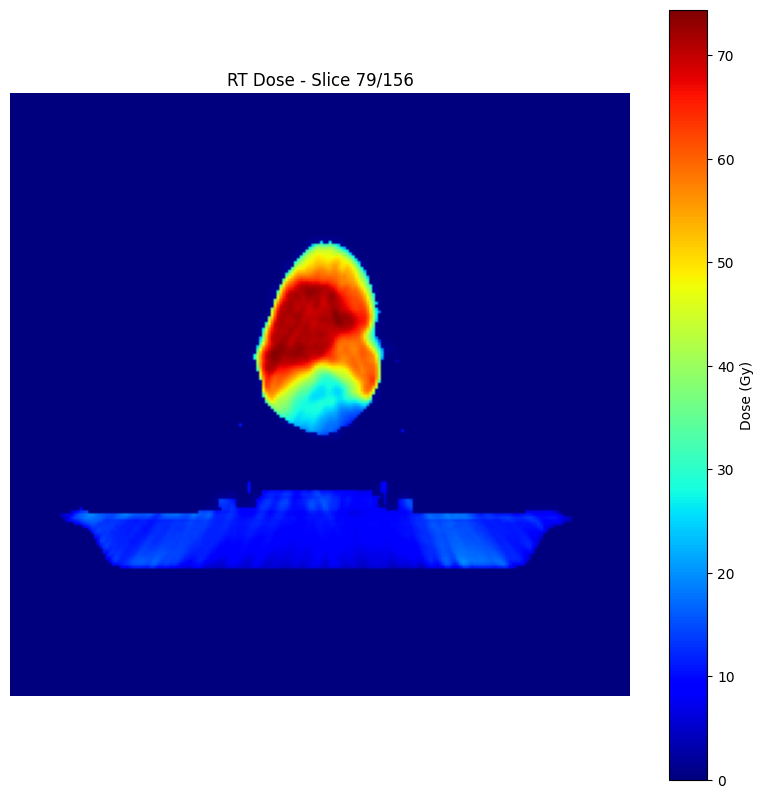

Dose range: 0.00 to 74.41 Gy


In [9]:
# Find and load the RT Dose file
rd_files = [f for f in os.listdir(path) if f.startswith("RD")]
if rd_files:
    rd_path = os.path.join(path, rd_files[0])
    rd = pydicom.dcmread(rd_path)
    print(f"Loaded RT Dose: {rd_path}")
    print(f"Dose Type: {rd.DoseType}")
    print(f"Dose Units: {rd.DoseUnits}")
    print(f"Dose Grid Scaling: {rd.DoseGridScaling}")
    
    # Get dose dimensions
    rows = rd.Rows
    cols = rd.Columns
    num_frames = rd.NumberOfFrames if hasattr(rd, 'NumberOfFrames') else 1
    
    print(f"\nDose grid size: {rows} x {cols} x {num_frames}")
    
    # Display middle slice of dose
    middle_frame = num_frames // 2
    
    # For 3D dose, need to extract the right frame
    if num_frames > 1:
        dose_array = rd.pixel_array[middle_frame] * rd.DoseGridScaling
    else:
        dose_array = rd.pixel_array * rd.DoseGridScaling
    
    plt.figure(figsize=(10, 10))
    plt.imshow(dose_array, cmap='jet')
    plt.colorbar(label='Dose (Gy)')
    plt.title(f"RT Dose - Slice {middle_frame+1}/{num_frames}")
    plt.axis('off')
    plt.show()
    
    print(f"Dose range: {np.min(dose_array):.2f} to {np.max(dose_array):.2f} Gy")
else:
    print("No RT Dose found")

## 9. Creating a Simple DVH (Dose Volume Histogram)

Calculating DVH for Cord...


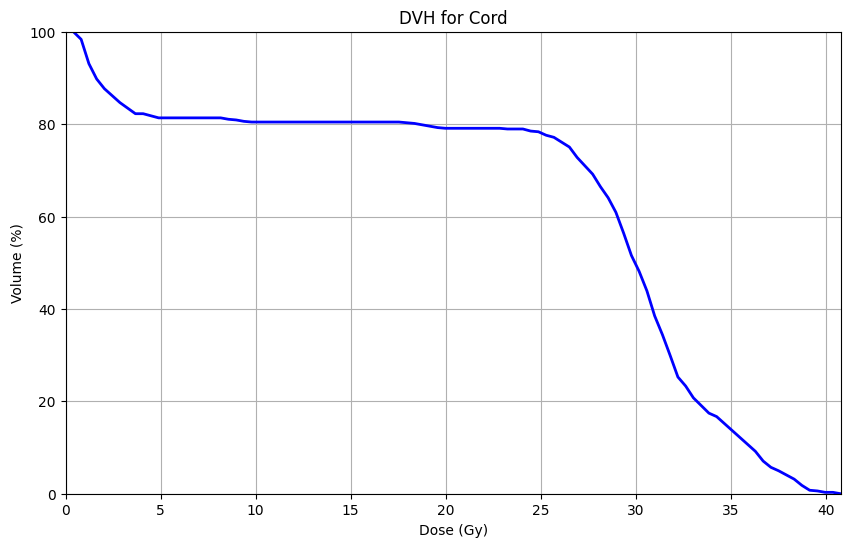

DVH Statistics for Cord:
Min Dose: 0.70 Gy
Max Dose: 40.78 Gy
Mean Dose: 25.51 Gy
Median Dose: 30.00 Gy
D95: 1.05 Gy
V20Gy: 79.10%


True

In [17]:
# Function to calculate a DVH for a structure
def calculate_dvh(structure_name, rs, rd):
    """
    Calculate a simple DVH (Dose Volume Histogram) for a structure
    
    A DVH summarizes the 3D dose distribution in a structure into a 2D graph:
    - X-axis: Dose (Gy)
    - Y-axis: Volume percentage of the structure
    - The curve shows what percentage of the structure volume receives at least a certain dose
    
    The calculation process:
    1. Create a binary mask of the structure within the dose grid
    2. Extract dose values that fall within this mask
    3. Calculate the cumulative histogram of these dose values
    """
    # Get structure contours
    contour_data = get_contour_data(rs, structure_name)
    if not contour_data:
        return None
    
    # Create a 3D mask for the structure
    # First, get the dose grid dimensions and parameters
    dose_rows = rd.Rows
    dose_cols = rd.Columns
    dose_frames = rd.NumberOfFrames if hasattr(rd, 'NumberOfFrames') else 1
    
    # Get dose grid coordinates
    dose_x = np.arange(dose_cols) * rd.PixelSpacing[1] + rd.ImagePositionPatient[0]
    dose_y = np.arange(dose_rows) * rd.PixelSpacing[0] + rd.ImagePositionPatient[1]
    dose_z = []
    
    # For 3D dose, get Z coordinates from grid frame offset vector
    if hasattr(rd, 'GridFrameOffsetVector'):
        for i in range(dose_frames):
            dose_z.append(rd.ImagePositionPatient[2] + rd.GridFrameOffsetVector[i])
    else:
        dose_z = [rd.ImagePositionPatient[2]]
    
    # Create an empty mask
    structure_mask = np.zeros((dose_frames, dose_rows, dose_cols), dtype=bool)
    
    # Fill the mask for each contour on each slice
    for contour in contour_data:
        # Find the closest Z slice
        z_coord = contour['z']
        closest_z_idx = np.argmin(np.abs(np.array(dose_z) - z_coord))
        
        # Get x,y points
        points = contour['triplets'][:, :2]
        
        # Create a 2D mask for this contour
        mask_2d = np.zeros((dose_rows, dose_cols), dtype=bool)
        
        # Convert points to pixel coordinates
        pixel_points = np.zeros_like(points)
        pixel_points[:, 0] = np.interp(points[:, 0], dose_x, np.arange(dose_cols))
        pixel_points[:, 1] = np.interp(points[:, 1], dose_y, np.arange(dose_rows))
        
        # Create a polygon and get a mask
        from matplotlib.path import Path
        poly_path = Path(pixel_points)
        
        # Create a grid of points
        x, y = np.meshgrid(np.arange(dose_cols), np.arange(dose_rows))
        grid_points = np.vstack((x.flatten(), y.flatten())).T
        
        # Check which points are inside the polygon
        mask = poly_path.contains_points(grid_points)
        mask_2d = mask.reshape(dose_rows, dose_cols)
        
        # Add this to the 3D mask
        structure_mask[closest_z_idx] = np.logical_or(structure_mask[closest_z_idx], mask_2d)
    
    # Get the dose values
    dose_values = np.zeros((dose_frames, dose_rows, dose_cols))
    for i in range(dose_frames):
        if dose_frames > 1:
            dose_values[i] = rd.pixel_array[i] * rd.DoseGridScaling
        else:
            dose_values[i] = rd.pixel_array * rd.DoseGridScaling
    
    # Extract dose values within the structure
    structure_doses = dose_values[structure_mask]
    
    return structure_doses

# Function to generate and display a DVH for a structure
def show_dvh(structure_name):
    """
    Generate and display a DVH for the given structure
    
    The DVH calculation provides key metrics for plan evaluation:
    - Min/Max/Mean doses: Basic statistical measures of dose in the structure
    - D95: Dose received by 95% of the structure volume (important for targets)
    - V20Gy: Percentage of structure volume receiving at least 20 Gy (critical for organs)
    
    These metrics help evaluate:
    - Target Coverage: Is the tumor getting enough dose?
    - Organ Sparing: Are healthy tissues protected?
    """
    print(f"Calculating DVH for {structure_name}...")
    structure_doses = calculate_dvh(structure_name, rs, rd)
    
    if structure_doses is not None and len(structure_doses) > 0:
        # Create the DVH
        hist, bin_edges = np.histogram(structure_doses, bins=100, range=(0, np.max(structure_doses)))
        dvh = 1.0 - np.cumsum(hist) / float(len(structure_doses))
        
        # Plot the DVH
        plt.figure(figsize=(10, 6))
        plt.plot(bin_edges[1:], dvh * 100, 'b-', linewidth=2)
        plt.grid(True)
        plt.xlabel('Dose (Gy)')
        plt.ylabel('Volume (%)')
        plt.title(f'DVH for {structure_name}')
        plt.xlim([0, np.max(structure_doses)])
        plt.ylim([0, 100])
        plt.show()
        
        # Print some DVH statistics
        print(f"DVH Statistics for {structure_name}:")
        print(f"Min Dose: {np.min(structure_doses):.2f} Gy")
        print(f"Max Dose: {np.max(structure_doses):.2f} Gy")
        print(f"Mean Dose: {np.mean(structure_doses):.2f} Gy")
        print(f"Median Dose: {np.median(structure_doses):.2f} Gy")
        
        # D95 (dose to 95% of the volume)
        sorted_doses = np.sort(structure_doses)
        d95_index = int(len(sorted_doses) * 0.05)  # 95% from the top
        d95 = sorted_doses[d95_index]
        print(f"D95: {d95:.2f} Gy")
        
        # V20 (volume receiving 20 Gy or more)
        v20 = np.sum(structure_doses >= 20.0) / len(structure_doses) * 100
        print(f"V20Gy: {v20:.2f}%")
        
        return True
    else:
        print(f"Could not calculate DVH for {structure_name} - no dose points found inside structure")
        return False

# Uncomment ONE of these DVH examples to demonstrate

# ===== DVH EXAMPLE 1: Target Volume =====
# show_dvh("PTV6996")  # Planning Target Volume

# ===== DVH EXAMPLE 2: Organs at risk - Spinal Cord =====
show_dvh("Cord")

# ===== DVH EXAMPLE 3: Parotid gland =====
# show_dvh("L Parotid")

# ===== DVH EXAMPLE 4: Tumor Volume =====
# show_dvh("GTV R Tonsil")

# ===== DVH EXAMPLE 5: Larynx =====
# show_dvh("Larynx")

## Additional Resources

- [DICOM Standard](https://www.dicomstandard.org/)
- [pydicom Documentation](https://pydicom.github.io/)
- [RT DICOM Primer](https://www.aapm.org/pubs/reports/RPT_246.pdf)
- [SimpleITK DICOM Documentation](https://simpleitk.readthedocs.io/en/master/Documentation/docs/source/DicomImageIO.html)